# Analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [180]:
import logging
import os
from random import randint
import pprint
import matplotlib.pyplot as plt
from suite2p import default_ops, version
from IPython.utils import io
import numpy as np

from constants import *
from logger import logger
from fileops import get_data_folders, get_output_equivalent, loadtif, savetif, filter_and_save
from parsers import parse_experiment_parameters
from stackers import stack_tifs
from viewers import view, dualview
from s2putils import run_suite2p, get_suite2p_data, view_registered_stack
from postpro import separate_runs, separate_trials, bound_in_time, get_relative_fluorescence_change, classify_by_response_type
from plotters import *
from filters import KalmanDenoiser

logger.setLevel(logging.INFO)

### General parameters

In [3]:
# Data directory 
rootdir = '../../data/yiyuan/raw/new_experiments_201911/' # Root directory for raw data
date = '11082019'
mouse = 'mouse6'
region = 'region1'
basedir = os.path.join(rootdir, date, mouse, region)

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [4]:
# Get raw list of subolders containing tifs 
datafolders = get_data_folders(basedir, exclude_patterns=['MIP', 'References'], include_patterns=['line3'])
logger.info(f'Identified data folders:\n{pprint.pformat(datafolders)}')

 18/10/2021 11:32:25: Identified data folders:
['../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100H

### Parse experimental parameters

In [98]:
# Parse every input folder and store parsed keys
plist = [parse_experiment_parameters(os.path.basename(x)) for x in datafolders]
pkeys = list(plist[0].keys())
# Derive dictionary of sorted values for each parsed parameter
sorted_single_pdict = {k: list(sorted(set([x[k] for x in plist]))) for k in pkeys}
# Check that only 1 value was parsed for parameters that should NEVER vary
singleton_params = ['duration', 'fps', '???']
for k in singleton_params:
    if len(sorted_single_pdict[k]) > 1:
        raise ValueError(f'more than 1 values identified for "{k}" field')
# Convert single value lists to their only constituting element
sorted_single_pdict = {k: v if len(v) > 1 else v[0] for k, v in sorted_single_pdict.items()}
# Log parsed parameters
s = '\n'.join([f'  - {k} = {v} {P_UNITS.get(k, "")}'for k, v in sorted_single_pdict.items()])
logger.info(f'Identified parameters: \n{s}')
tstim = sorted_single_pdict['duration']
fps = sorted_single_pdict['fps'] 

 18/10/2021 16:29:57: Identified parameters: 
  - line = line3 
  - trial_length = 100 
  - ??? = 100.0 
  - duration = 0.2 s
  - fps = 3.56 fps
  - P = [0.0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8] MPa
  - DC = [5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0] %
  - run = [743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757] 


### Sort folders by run ID

In [79]:
# Check that all data folders are from the same parent
pardirs = [os.path.split(x)[0] for x in datafolders]
assert pardirs.count(pardirs[0]) == len(pardirs), 'Data folders have different parrents'
# Sort folders once asserted that they belong to the same parent
datafolders, plist = zip(*sorted(zip(datafolders, plist), key=lambda x: x[1]['run']))
logger.info(f'Sorted data folders:\n{pprint.pformat(datafolders)}')

 18/10/2021 15:26:15: Sorted data folders:
('../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-747',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200

### Merge TIFs into stack

In [7]:
stack_fpaths = []
for datafolder in datafolders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpaths.append(stack_tifs(datafolder, overwrite=False))

 18/10/2021 11:32:28: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 18/10/2021 11:32:28: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744.tif" already exists
 18/10/2021 11:32:28: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745.tif" already exists
 18/10/2021 11:32:28: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746.tif" already exists
 18/10/2021 11:32:28: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-747.tif" already exists
 18/10/2021 11:32:28: "/Users/tlemaire/Documents/data/yiyuan/stacked/n

### Visualize a randomly chosen stack

 18/10/2021 11:32:31: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755.tif"
 18/10/2021 11:32:35: stack size: (1600, 256, 256)
 18/10/2021 11:32:35: rendering stack view...


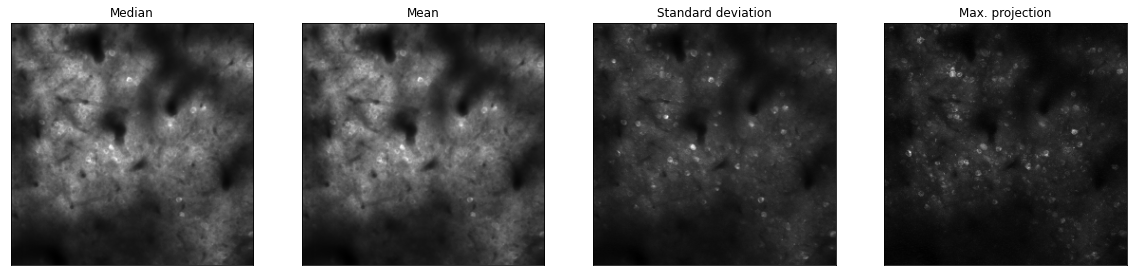

In [8]:
ifile = randint(0, len(stack_fpaths) -1)
stack = loadtif(stack_fpaths[ifile])
fig = plot_stack_summary(stack)
view(stack)

We notice a significant amount of Speckle noise in the acquired images, which must be removed.

## Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [9]:
# Define Kalman filter
kd = KalmanDenoiser(G=0.5, V=0.05, npad=10)

# Denoise every TIF stack and save outputs in specific directory 
filtered_stack_fpaths = filter_and_save(kd, stack_fpaths, overwrite=False)

 18/10/2021 11:32:37: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 18/10/2021 11:32:37: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744.tif" already exists
 18/10/2021 11:32:37: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745.tif" already exists
 18/10/2021 11:32:37: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746.tif" already exists
 18/10/2021 11:32:37: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.

### View filtering output for a particular stack

 18/10/2021 11:42:45: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-755.tif"
 18/10/2021 11:42:49: stack size: (1600, 256, 256)
 18/10/2021 11:42:49: rendering stacks view...


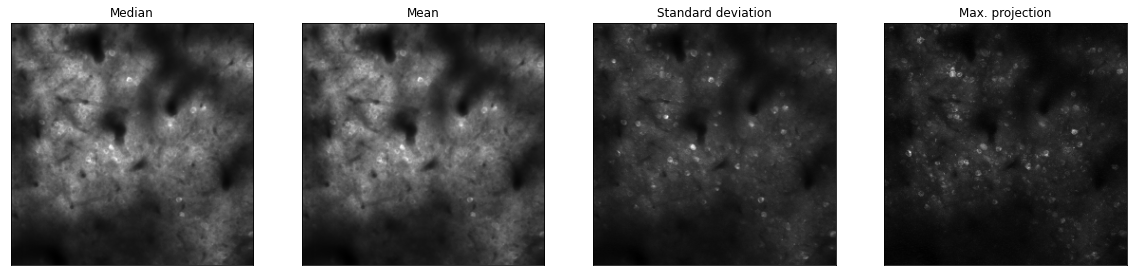

In [10]:
filtered_stack = loadtif(stack_fpaths[ifile])
fig = plot_stack_summary(filtered_stack)
dualview(stack, filtered_stack, title1='Raw', title2='Filtered', suptitle=kd)

## Functional segmentation

We will now use the suite2p pipeline to identify ROIs in our field of view and compute their fluorescence timecourse.

### Determine suite2p input data

In [11]:
# Determine input filepaths (raw or filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Get the list of folders containing the input filepaths
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
logger.info(f'Suite2p input directories:\n{pprint.pformat(s2p_input_dirs)}')

 18/10/2021 11:42:59: Suite2p input directories:
['/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1']


### Set suite2p pipeline parameters

In [94]:
# Custom options
myops = {
    'tau': TAU_GCAMP6_DECAY,  # timescale mof the sensor (in our case GCaMP6s)
    'fs': sorted_single_pdict['fps'],  # sampling rate (per plane)
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': True,  # perform PCA denoising of the registered stack prior to ROI detection 
}

ops = default_ops()  # get default run options
ops.update(myops)  # update with personal options
logger.info(f'Suite2p {version} with run options:\n{pprint.pformat(ops)}')

 18/10/2021 16:27:46: Suite2p 0.10.2 with run options:
{'1Preg': False,
 'align_by_chan': 1,
 'allow_overlap': False,
 'anatomical_only': 0,
 'aspect': 1.0,
 'baseline': 'maximin',
 'batch_size': 500,
 'bidi_corrected': False,
 'bidiphase': 0,
 'block_size': [128, 128],
 'bruker': False,
 'bruker_bidirectional': False,
 'cellprob_threshold': 0.0,
 'chan2_thres': 0.65,
 'classifier_path': 0,
 'combined': True,
 'connected': True,
 'delete_bin': False,
 'denoise': True,
 'diameter': 0,
 'do_bidiphase': False,
 'do_registration': 1,
 'fast_disk': [],
 'flow_threshold': 1.5,
 'force_refImg': False,
 'force_sktiff': False,
 'frames_include': -1,
 'fs': 3.56,
 'functional_chan': 1,
 'h5py': [],
 'h5py_key': 'data',
 'high_pass': 100,
 'ignore_flyback': [],
 'inner_neuropil_radius': 2,
 'keep_movie_raw': False,
 'lam_percentile': 50.0,
 'look_one_level_down': False,
 'max_iterations': 20,
 'max_overlap': 0.75,
 'maxregshift': 0.1,
 'maxregshiftNR': 5,
 'mesoscan': False,
 'min_neuropil_pixels

### Run suite2p

In [13]:
output_ops = run_suite2p(ops=ops, db={'data_path': s2p_input_dirs}, overwrite=False)
diff_ops = set(output_ops.keys()).difference(ops.keys())
logger.info(f'New keys generated upon suite2p run:\n{pprint.pformat(diff_ops)}')

/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0
{'data_path': ['/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1']}
tif
** Found 15 tifs - converting to binary **
8000 frames of binary, time 3.90 sec.
16000 frames of binary, time 7.78 sec.
24000 frames of binary, time 10.59 sec.
time 10.78 sec. Wrote 24000 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
----------- REGISTRATION
registering 24000 frames


/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/suite2p/registration/utils.py:234: RuntimeWarning: invalid value encountered in apply_dotnorm
  return ifft2(apply_dotnorm(fft2(mov), img)) #.astype(np.complex64)


Reference frame, 4.98 sec.
Registered 2000/24000 in 22.36s
Registered 4000/24000 in 46.51s
Registered 6000/24000 in 70.40s
Registered 8000/24000 in 92.91s
Registered 10000/24000 in 114.01s
Registered 12000/24000 in 137.61s
Registered 14000/24000 in 161.19s
Registered 16000/24000 in 184.29s
Registered 18000/24000 in 207.01s
Registered 20000/24000 in 229.34s
Registered 22000/24000 in 253.41s
Registered 24000/24000 in 278.89s
added enhanced mean image
----------- Total 286.14 sec


/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/suite2p/registration/utils.py:234: RuntimeWarning: invalid value encountered in apply_dotnorm
  return ifft2(apply_dotnorm(fft2(mov), img)) #.astype(np.complex64)


Registration metrics, 16.03 sec.
NOTE: applying default /Users/tlemaire/.suite2p/classifiers/classifier_user.npy
----------- ROI DETECTION
Binning movie in chunks of length 04
Binned movie [6000,254,254] in 5.34 sec.
Binned movie denoised (for cell detection only) in 72.86 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 5.00, threshold 25.00 
0 ROIs, score=394.46
Detected 815 ROIs, 414.92 sec
After removing overlaps, 732 ROIs remain
----------- Total 495.36 sec.
----------- EXTRACTION
Masks created, 0.81 sec.


/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_ipix' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/suite2p/extraction/extract.py", line 105:
@njit(parallel=True)
def matmul_traces(Fi, data, cell_ipix, cell_lam):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_lam' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/

Extracted fluorescence from 732 ROIs in 24000 frames, 15.48 sec.
----------- Total 16.99 sec.
----------- CLASSIFICATION
['compact', 'skew', 'npix_norm']
----------- Total 0.14 sec.
----------- SPIKE DECONVOLUTION
----------- Total 0.84 sec.
Plane 0 processed in 815.67 sec (can open in GUI).
total = 826.48 sec.
TOTAL RUNTIME 826.48 sec
 18/10/2021 12:01:00: New keys generated upon suite2p run:
{'Lx',
 'Lxc',
 'Ly',
 'Lyc',
 'NRsm',
 'Vcorr',
 'Vmap',
 'Vmax',
 'Vsplit',
 'badframes',
 'corrXY',
 'corrXY1',
 'data_path',
 'date_proc',
 'filelist',
 'first_tiffs',
 'frames_per_file',
 'frames_per_folder',
 'ihop',
 'input_format',
 'max_proj',
 'meanImg',
 'meanImgE',
 'nblocks',
 'nframes',
 'ops_path',
 'refImg',
 'regDX',
 'regPC',
 'reg_file',
 'rmax',
 'rmin',
 'save_path',
 'spatscale_pix',
 'tPC',
 'timing',
 'xblock',
 'xoff',
 'xoff1',
 'xrange',
 'yblock',
 'yoff',
 'yoff1',
 'yrange'}


### Load suite2p ouput data

In [29]:
s2p_data = get_suite2p_data(output_ops['save_path'], withops=True)
s2p_ops = s2p_data.pop('ops')

### Plot suite2p summary images

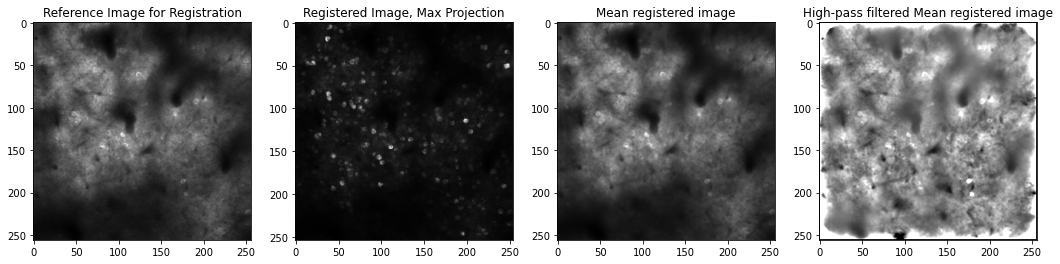

In [30]:
fig = plot_suite2p_registration_images(s2p_ops)

### Plot suite2p registration offsets

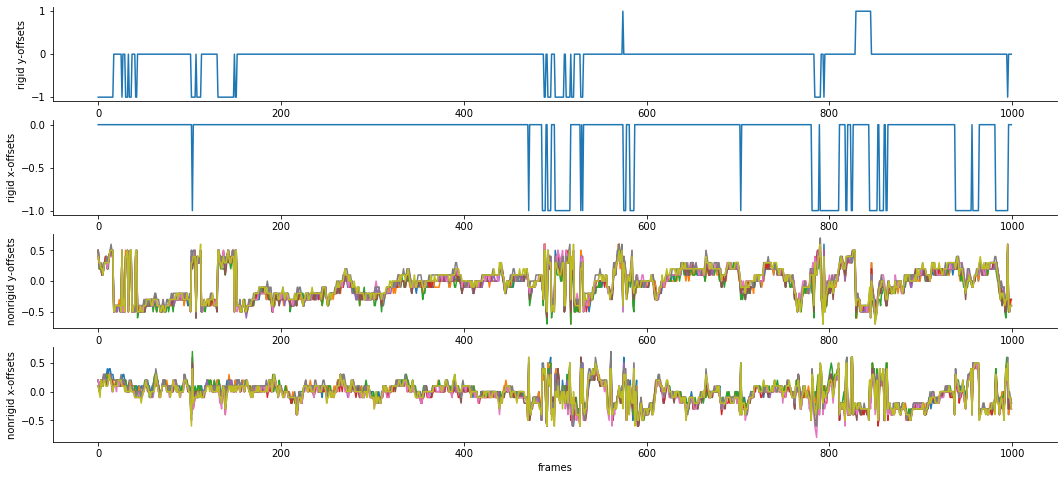

In [31]:
fig = plot_suite2p_registration_offsets(s2p_ops)

### Visualize registered stack

In [32]:
view_registered_stack(s2p_ops)

interactive(children=(IntSlider(value=800, description='t', max=1600), Output()), _dom_classes=('widget-intera…

### Inspect suite2p ROIs

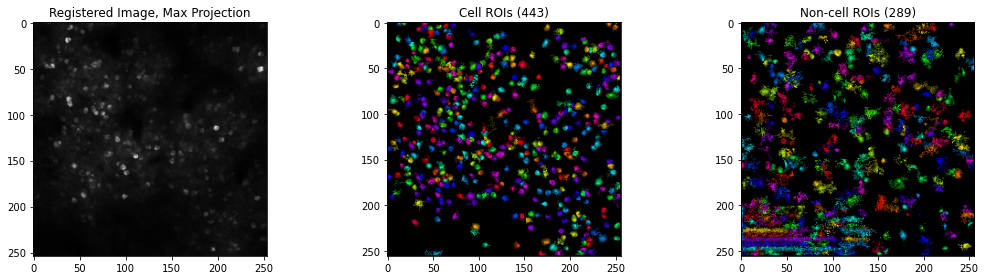

In [33]:
fig = plot_suite2p_ROIs(s2p_data, s2p_ops)

### Filter out non-cell ROIs

In [51]:
cell_data = {}
iscell, cellprob = s2p_data['iscell'].T
cell_idx = np.array(iscell.nonzero()).reshape(-1)
s2p_cell_data = {k: v[cell_idx] for k, v in s2p_data.items()}
del s2p_cell_data['iscell']

### Compute fluorescence data

In [80]:
F = s2p_cell_data['F'] - NEUROPIL_FACTOR * s2p_cell_data['Fneu']
ncells = F.shape[0]

### Split the data into separate runs

In [81]:
nruns = len(s2p_input_fpaths)
F_per_run = separate_runs(F, nruns)

### Plot fluorescence timecourse for a random run 

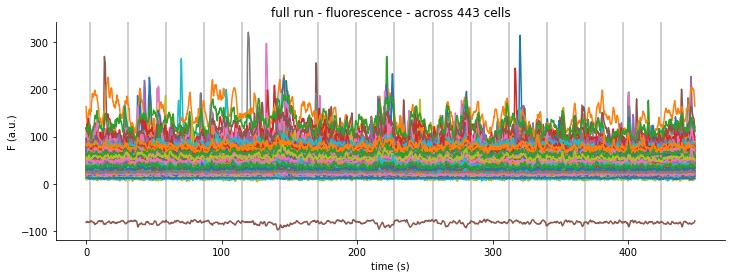

In [82]:
irun = randint(0, nruns -1)
fig = plot_run(F_per_run[:, irun, :], FPS, 'F (a.u.)', title=f'fluorescence - across {F.shape[0]} cells', mark_stim=True)

### Split the data into separate trials 

In [108]:
F_per_trial = separate_trials(F_per_run, NTRIALS_PER_RUN)

### Substitute stim frame for each trial ???

### Ignore 1st trial of each run???

### Compute relative fluorescence change for each trial

In [165]:
dFF_per_trial = get_relative_fluorescence_change(F_per_trial, I_BASELINE)

### Plot Calcium transients for a particular cell and run

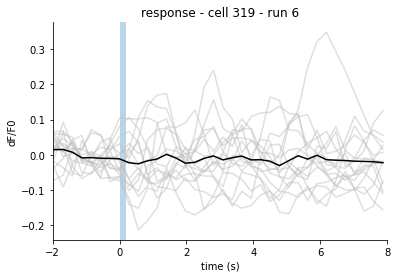

In [166]:
icell = randint(0, ncells -1)
fig = plot_response(
    dFF_per_trial[icell, irun], FPS, title=f'cell {icell} - run {irun}',
    ylabel='dF/F0', avgmode=True, tstim=tstim)

### Classify cells by response type

 18/10/2021 22:37:44: computing z-score distributions
 18/10/2021 22:37:44: averaging
(443, 15, 7)
 18/10/2021 22:37:44: Identified cell classes:
-  negative: 50
-  neutral: 393
-  positive: 0


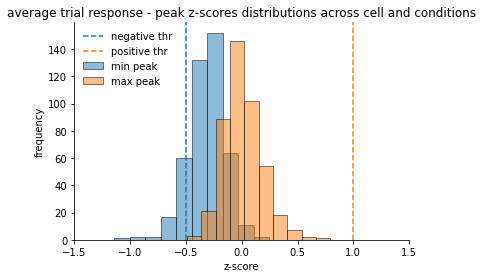

In [190]:
cell_classes = classify_by_response_type(dFF_per_trial)
s = "\n".join([f"-  {v}: {sum(cell_classes == k)}" for k, v in RESPONSE_CODES.items()])
logger.info(f'Identified cell classes:\n{s}')

### Remove outliers

### Plot average Calcium transients across cells

(443, 15, 16, 100)


ValueError: too many values to unpack (expected 2)

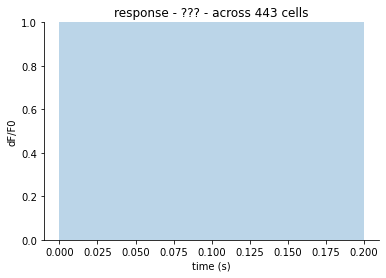

In [91]:
# Average fluorescence data across trials
dFF_trial_avg = dFF_per_trial.mean(axis=1)
print(dFF_per_trial.shape)
fig = plot_response(dFF_per_trial[:, irun], FPS, title=f'{k} - across {ncells} cells', ylabel='dF/F0', avgmode=True, tstim=tstim)